##Abha Himani Mudit Saxena Project

In [2]:
from google.colab import drive     ## we have forced mounted folder from drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
Root ="/content/drive/MyDrive/Cancer"
os.chdir(Root)                                  ## taken the main folder as root, used the os library

In [4]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image   
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy   
from keras.models import Sequential, Model ## Model is for model building, and sequential is for the layers
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam 
import cv2 ##imported opencv

In [8]:
data = '/content/drive/MyDrive/Cancer'     # we have imported data, and benign and malignant cancer
No_breast_cancer = '/content/drive/MyDrive/Cancer/benign'
Yes_breast_cancer = '/content/drive/MyDrive/Cancer/malignant'

In [9]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']     
filepaths=[] 
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)      ## we have put all the file paths and labels in the list
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))    

filepaths:  1834    labels:  1834


In [11]:
## here we have use the pandas library, to keep the entire data in filepath and labels
Files=pd.Series(filepaths, name='filepaths')    
Label=pd.Series(labels, name='labels')   
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1834,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Cancer/benign/SOB_B_A-1...,No
1,/content/drive/MyDrive/Cancer/benign/SOB_B_A-1...,No
2,/content/drive/MyDrive/Cancer/benign/SOB_B_A-1...,No
3,/content/drive/MyDrive/Cancer/benign/SOB_B_A-1...,No
4,/content/drive/MyDrive/Cancer/benign/SOB_B_A-1...,No


In [12]:
print(df['labels'].value_counts())


Yes    1240
No      594
Name: labels, dtype: int64


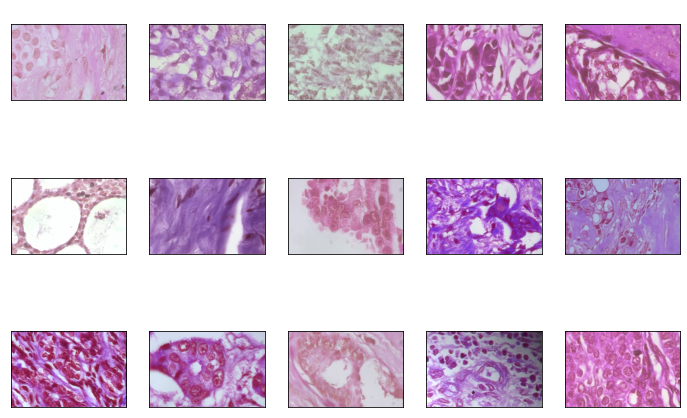

In [13]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)
## randomly splitting data into train,test and valid
print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")      

train set shape: (1567, 2)
test set shape: (92, 2)
validation set shape: (175, 2)


In [15]:
## here we have augmented the image
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)   

In [16]:

train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1567 validated image filenames belonging to 2 classes.
Found 175 validated image filenames belonging to 2 classes.
Found 92 validated image filenames belonging to 2 classes.


In [17]:
train_gen.class_indices
 ## we have shown that NO is 0 and Yes is 1

{'No': 0, 'Yes': 1}

## Transfer Learning we have used resnet 50 as the model

In [18]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  

# Freeze the base_model   

base_model.trainable = False    

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
49/49 [==============================] - 49s 954ms/step - loss: 0.3815 - accuracy: 0.8277 - val_loss: 0.3939 - val_accuracy: 0.8571
Epoch 2/100
49/49 [==============================] - 46s 935ms/step - loss: 0.3942 - accuracy: 0.8347 - val_loss: 0.3707 - val_accuracy: 0.8571
Epoch 3/100
49/49 [==============================] - 49s 994ms/step - loss: 0.3806 - accuracy: 0.8354 - val_loss: 0.3593 - val_accuracy: 0.8686
Epoch 4/100
49/49 [==============================] - 43s 875ms/step - loss: 0.3757 - accuracy: 0.8411 - val_loss: 0.3691 - val_accuracy: 0.8343
Epoch 5/100
49/49 [==============================] - 45s 925ms/step - loss: 0.3753 - accuracy: 0.8411 - val_loss: 0.3578 - val_accuracy: 0.8400
Epoch 6/100
49/49 [==============================] - 43s 885ms/step - loss: 0.3696 - accuracy: 0.8379 - val_loss: 0.3702 - val_accuracy: 0.8743
Epoch 7/100
49/49 [==============================] - 43s 879ms/step - loss: 0.3842 - accuracy: 0.8366 - val_loss: 0.3582 - val_accuracy:

In [20]:
model.save("model.h5")

In [21]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Cancer/malignant/SOB_M_DC-14-10926-400-006.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255  

pred = loaded_model.predict(input_data) ## keras has a function called predict which predicts the data, according to how our model is trained
if pred >= 0.5:
  print("Yes")
else:
  print("No")

Yes
